In [1]:
!pip install seaborn pandas matplotlib skunk svglib

     |████████████████████████████████| 896 kB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 43.7 MB/s eta 0:00:01
  Created wheel for svglib: filename=svglib-1.2.1-py3-none-any.whl size=30232 sha256=4e1ec01049de2e12b245756b3e4a257256462dcdd8966e44274aa82c0517f6bb
  Stored in directory: /home/whitead/.cache/pip/wheels/92/90/60/d1e17c1df04259938d4de3b499f12392599fb5215e646ab941
Successfully built svglib


In [2]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [95]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
my_cmap = 'rainbow'
print(symd.__version__)

0.2.1


In [4]:
print("0\u2264x\u22641/2;0\u2264y\u22641")

0≤x≤1/2;0≤y≤1


In [5]:
rot = 7
genpos = []
for ri in range(rot):
    c = np.round(np.cos(ri * np.pi * 2 / rot), 4)
    s = np.round(np.sin(ri * np.pi * 2 / rot), 4)
    if ri == 1:
        #asymm = f'0≤x≤{c};0≤y≤{s}'
        asymm = f'1/2≤x≤1.0;1/2≤y≤1.0'
    genpos.append(f'{c}x {-s:+}y {-0.5 * c + 0.5 * s + 0.5:+},{s}x {c:+}y {-0.5 * s - 0.5 * c + 0.5:+}')
specpos = [{
            'name': 'a',
            'size': 1,
            'sites': ['1/2, 1/2']
            }]
    
my_group = {
    'lattice': 'Oblique',
    'genpos': genpos,
    'asymm_unit': asymm,
    'specpos': specpos
}
print(my_group)

{'lattice': 'Oblique', 'genpos': ['1.0x -0.0y +0.0,0.0x +1.0y +0.0', '0.6235x -0.7818y +0.57915,0.7818x +0.6235y -0.20265', '-0.2225x -0.9749y +1.0987,0.9749x -0.2225y +0.12380000000000002', '-0.901x -0.4339y +1.16745,0.4339x -0.901y +0.73355', '-0.901x +0.4339y +0.73355,-0.4339x -0.901y +1.16745', '-0.2225x +0.9749y +0.12380000000000002,-0.9749x -0.2225y +1.0987', '0.6235x +0.7818y -0.20265,-0.7818x +0.6235y +0.57915'], 'asymm_unit': '1/2≤x≤1.0;1/2≤y≤1.0', 'specpos': [{'name': 'a', 'size': 1, 'sites': ['1/2, 1/2']}]}


In [78]:
def run_sim(n, number_density, group, images, w=None, retries=50, pos_frames=0, steps=10**6):
    for i in range(retries):
        try:
            np.random.seed(i)
            cell = symd.groups.get_cell(number_density, group, 2, n, w)
            md = symd.Symd(nparticles=n, cell=cell, ndims=2, images=images, force='lj', wyckoffs=w,
              group=group, steps=steps, exeDir='quasi', start_temperature=0.5, temperature=0.1, pressure=0.25)
            md.remove_overlap()      
            md.runParams['box_update_period'] = 10
            md.runParams['langevin_gamma'] = 0.5
            md.log_positions(frames=pos_frames)
            try:
                md.run()
            except RuntimeError as e:
                d = md.number_density()
                if d < 0.6:
                    print('Not dense enough, retrying', d)
                    continue
                    
            # Basically E-min
            md.runParams['start_temperature'] = 0.1
            md.runParams['temperature'] = 1e-2
            md.runParams['langevin_gamma'] = 0.5
            md.runParams['Pressure'] = None
            md.runParams['box_update_period'] = 0
            md.runParams['steps'] = steps // 10
            if pos_frames > 0:
                md.log_positions(filename='equil.xyz', frames=pos_frames // 10)
            try:
                md.run()
            except RuntimeError as e:
                continue
            config = md.positions[-1]
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md


In [81]:
md = run_sim(256, 0.1, my_group, [0, 0], pos_frames=1000, w=[1])

{"steps": 1000000, "n_particles": 256, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.5, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 10, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "quasi/final_positions.dat", "cell_log_file": "quasi/cell_log_file.dat", "print_period": 10000.0, "cell": [42.1125, 0.0, 0.0, 40.3332], "lj_epsilon": 1, "lj_sigma": 1, "images": [0, 0], "start_positions": "quasi/final_positions.dat", "group": "quasi/group-custom.json", "wyckoffs": [{"group": "quasi/group-custom-00.json", "n_particles": 1}], "position_log_period": 1000, "positions_log_file": "quasi/positions.xyz"}
Info: You are running version b94f-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-custom with 255 particles and 7 members
Info: Loaded group group-custom-0 with 1 particles and 1 memb

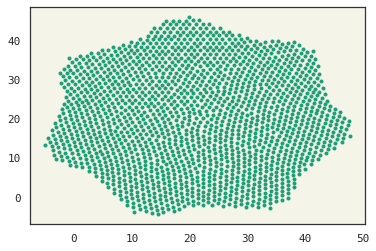

In [113]:
plt.plot(md.positions[-1,:,0], md.positions[-1,:, 1], '.')

In [124]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot_traj(traj, title='@_172135352171_', color='#333333', fps=60, M=0, cmap=my_cmap):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps + 2
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 1080 / dpi), dpi=dpi)
    tc = color#np.linalg.norm(traj[-1] - traj[-1,M-1], axis=-1)
    points = [ax.scatter(traj[0,:,0], traj[0,:,1], cmap=cmap,
                         c=tc, marker='o', linewidths=1, s=15**2, edgecolors='#999')]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')    
    xlim = np.min(traj[-1, :, 0]), np.max(traj[-1, :, 0])
    ylim = np.min(traj[-1, :, 1]), np.max(traj[-1, :, 1])
    dx = xlim[1] - xlim[0]    
    dy = ylim[1] - ylim[0]
    cx, cy = traj[-1, M-1, :2]
    s = 0.75
    xlim = [cx - dx * s, cx + dx * s]
    ylim = [cy - dy * s, cy + dy * s]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')    
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points[0].remove()        
        points[0] = ax.scatter(traj[i,:,0], traj[i,:,1], cmap=cmap,
                               c=tc, marker='o',linewidths=0, s=7**2, edgecolors='#999')
        plt.draw()
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    #composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation', '-crf', '18'])
    composite.write_gif(output, fps=60)

t:   1%|          | 2/389 [00:00<00:35, 10.84it/s, now=None]

MoviePy - Building file 7fold.gif with imageio.



t:  33%|███▎      | 127/389 [00:22<00:46,  5.59it/s, now=None]


t:  65%|██████▍   | 251/389 [00:43<00:23,  5.82it/s, now=None]


t:  96%|█████████▋| 375/389 [01:05<00:02,  5.69it/s, now=None]


t: 100%|██████████| 389/389 [01:07<00:00,  5.78it/s, now=None]
                                                              

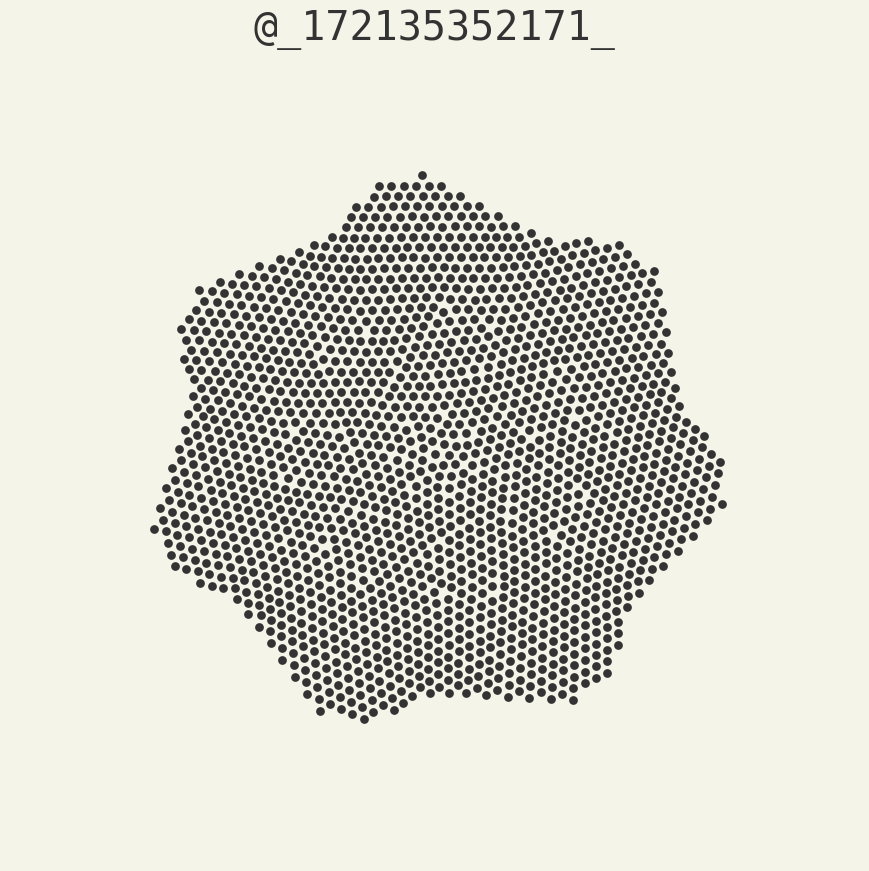

In [125]:
c = plot_traj(md.positions, M=256)
write_video([c], '7fold.gif')

In [111]:
md.positions.shape

(284, 1786, 2)